Testing TF, GPU drivers and ROCm support.

In [1]:
import tensorflow as tf

print('TF version: {}'.format(tf.__version__))
print('GPU support enabled: {}'.format(tf.test.is_built_with_gpu_support()))
print('ROCm support enabled: {}'.format(tf.test.is_built_with_rocm()))

TF version: 1.15.0
GPU support enabled: True
ROCm support enabled: True


Imports.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sinh, cosh
import time 

import numba
from numba import njit

import tensorflow as tf

import deepxde as dde

# 1D Bioheat transfer time-invariant equation

Time-variant 1D Pennes equation:

$$
\nabla(k \nabla T) + Q_b + Q_m + Q_{ext} = c_v \rho \frac{\partial T}{\partial t}
$$

where $Q_b = w_b \cdot T_a - w_b \cdot T$.

Time-invariant form:

$$
k \cdot \frac{d^2 T}{d x^2} - w_b \cdot T(x) + w_b \cdot T_a + Q_m + Q_{ext} = 0
$$

In [3]:
# consts 
c_b = 4200 
rho_b = 1e3 
om_b = 5e-4
c = 4200 
h_f = 100;
T_c = 37
L = 3e-2

# random variables
K = 0.5
w_b = c_b*rho_b*om_b
Q_m = 33800
h_0 = 10
T_f = 25
T_a = 37
rvs = [K, w_b, T_a, Q_m, h_0, T_f]
rvs = np.array(rvs).reshape(1, -1)

# solution domain
x = np.linspace(0, L, num=49)

Analytical solution.

In [4]:
def analyticSol(x):
    A = np.sqrt(w_b/K)
    lterm = (T_c - T_a - Q_m/w_b) * (A * cosh(A * x)  +\
                +  (h_0/K) * sinh(A * x)) / (A * cosh(A * L) + (h_0/K) * sinh(A * L))
    rterm = h_0/K * (T_f - T_a - Q_m/w_b) * sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * cosh(A * L) + (h_0/K) * sinh(A * L)) 

    return  T_a + Q_m/w_b + lterm + rterm

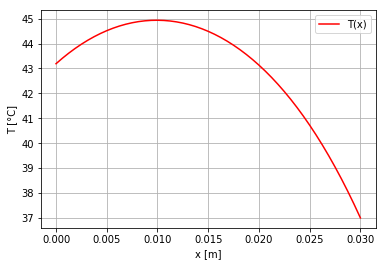

In [5]:
T = analyticSol(x)
plt.plot(x, T, 'r-', label='T(x)')
plt.xlabel('x [m]')
plt.ylabel('T [°C]')
plt.grid()
plt.legend(loc='best')
plt.show()

Monte Carlo simulation.

In [6]:
@njit
def monteCarloSim(x, rvs, coef_var=0.2, num_samples=1000, num_iters=1000):
    sims_global = np.empty(shape=(num_iters, num_samples, rvs.shape[1]))
    for i in range(num_iters):
        xi = np.random.rand(num_samples, len(rvs)) # random values
        sims = np.zeros(shape=xi.shape)            # empty simulations matrix
        
        rvs_min = rvs - coef_var*rvs              
        rvs_max = rvs + coef_var*rvs

        sims = rvs_min + (rvs_max - rvs_min) * xi
        sims_global[i, :, :] = sims
    return sims_global

@njit
def monteCarloT(x, K, w_b, T_a, Q_m, h_0, T_f):
    A = np.sqrt(w_b/K)
    lterm = (T_c - T_a - Q_m/w_b) * (A * cosh(A * x)  +\
                +  (h_0/K) * sinh(A * x)) / (A * cosh(A * L) + (h_0/K) * sinh(A * L))
    rterm = h_0/K * (T_f - T_a - Q_m/w_b) * sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * cosh(A * L) + (h_0/K) * sinh(A * L)) 

    return T_a + Q_m/w_b + lterm + rterm

@njit
def monteCarloResample(x, mc):
    num_iters, num_samples, n_rv = mc.shape
    
    T_mc = np.empty(shape=(num_iters, num_samples, x.shape[0]))
    
    for it in range(num_iters):
        for sample in range(num_samples):
            T_mc[it, sample, :] = monteCarloT(x, mc[it, sample, 0], mc[it, sample, 1], mc[it, sample, 2], mc[it, sample, 3], mc[it, sample, 4], mc[it, sample, 5])
    return T_mc

In [7]:
num_samples = 1000
num_iters = 100
coef_var = 0.2

start = time.time()
mc = monteCarloSim(x, rvs, coef_var, num_samples, num_iters)
T_mc = monteCarloResample(x, mc)
print('Simulation time: {}s'.format(time.time() - start))

Simulation time: 1.3834335803985596s


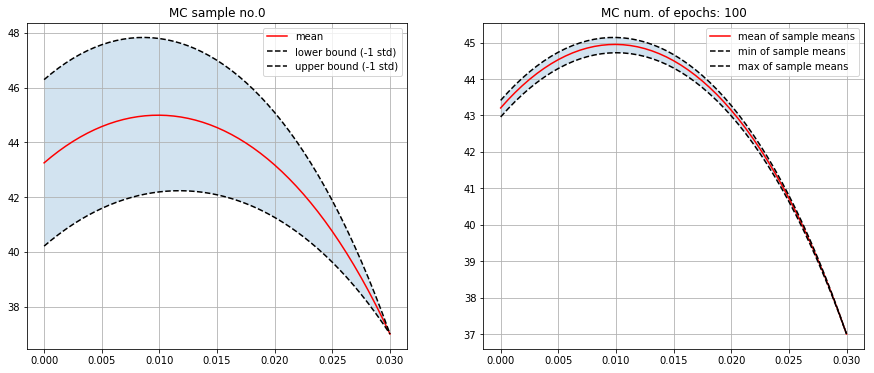

In [8]:
plt.figure(figsize=(15,6))

# single sample
_sample_exmp = 0
T_mc0 = T_mc[_sample_exmp]
T_mc0_mean = np.mean(T_mc0, axis=0)
T_mc0_std = np.std(T_mc0, axis=0)
T_mc0_lower_bound = T_mc0_mean - T_mc0_std
T_mc0_upper_bound = T_mc0_mean + T_mc0_std

plt.subplot(1,2,1)
plt.plot(x, T_mc0_mean, 'r-', label='mean')
plt.plot(x, T_mc0_lower_bound, 'k--', label='lower bound (-1 std)')
plt.plot(x, T_mc0_upper_bound, 'k--', label='upper bound (-1 std)')
plt.fill_between(x, T_mc0_lower_bound, T_mc0_upper_bound, alpha=0.2)
plt.legend(loc='best')
plt.title('MC sample no.{}'.format(_sample_exmp))
plt.grid()

# full simulation
T_mc_mean = np.mean(T_mc, axis=1)
T_mean = np.mean(T_mc_mean, axis=0)
T_std = np.std(T_mc_mean, axis=0)
T_lower_bound = T_mc_mean[np.argmin(T_mc_mean[:, 0], axis=0)]
T_upper_bound = T_mc_mean[np.argmax(T_mc_mean[:, 0], axis=0)]

plt.subplot(1,2,2)
plt.plot(x, T_mean, 'r-', label='mean of sample means')
plt.plot(x, T_lower_bound, 'k--', label='min of sample means')
plt.plot(x, T_upper_bound, 'k--', label='max of sample means')
plt.fill_between(x, T_lower_bound, T_upper_bound, alpha=0.2)
plt.legend(loc='best')
plt.title('MC num. of epochs: {}'.format(num_iters))
plt.grid()

plt.show()

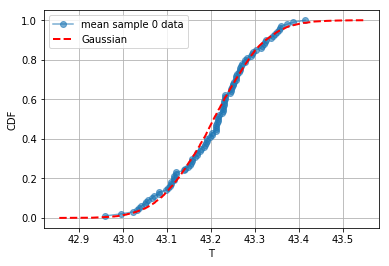

In [9]:
# distribution of sample means
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

_exmp = 0
x_cdf, y_cdf = ecdf(T_mc_mean[:, _exmp])
plt.plot(x_cdf, y_cdf, marker='o', alpha=0.6, label='mean sample 0 data')

samples = np.random.normal(np.mean(T_mc_mean[:, _exmp]), np.std(T_mc_mean[:, _exmp]), 10000)
x_theor, y_theor = ecdf(samples)
plt.plot(x_theor, y_theor, 'r--', linewidth=2, label='Gaussian')

plt.xlabel('T')
plt.ylabel('CDF')
plt.grid()
plt.legend(loc='best')
plt.show()


FEM.